In [1]:
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt

np.random.seed(0)

# 수치미분 함수

def numerical_derivative(f, x):
    delta_x = 1e-4 # 0.0001
    grad = np.zeros_like(x)
    
    it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
    
    while not it.finished:
        idx = it.multi_index        
        tmp_val = x[idx]
        x[idx] = float(tmp_val) + delta_x
        fx1 = f(x) # f(x+delta_x)
        
        x[idx] = float(tmp_val) - delta_x 
        fx2 = f(x) # f(x-delta_x)
        grad[idx] = (fx1 - fx2) / (2*delta_x)
        
        x[idx] = tmp_val 
        it.iternext()   
        
    return grad

# sigmoid 함수

def sigmoid(x):
    return 1 / (1+np.exp(-x))

In [2]:
class MNIST_Test:
    def __init__(self, i_node, h_node, o_node, lr):
        self.learning_rate = lr
        
        self.W2 = np.random.rand(i_node, h_node)
        self.b2 = np.random.rand(1)
        
        self.W3 = np.random.rand(h_node, o_node)
        self.b3 = np.random.rand(1)
        
        print("========== Diabetes Object is created. ==========\n")
        
    def feed_forward(self, x_data, t_data):
        delta = 1e-7
        
        z2 = np.dot(self.x_data, self.W2) + self.b2
        a2 = sigmoid(z2)
        
        z3 = np.dot(a2, self.W3) + self.b3
        a3 = sigmoid(z3)
        
        return -np.sum((self.t_data*np.log10(a3 + delta)) + ((1 - self.t_data)*np.log10((1 - a3) + delta)))

    def loss_val(self):
        delta = 1e-7
        
        z2 = np.dot(self.x_data, self.W2) + self.b2
        a2 = sigmoid(z2)
        
        z3 = np.dot(a2, self.W3) + self.b3
        a3 = sigmoid(z3)
        
        return -np.sum((self.t_data*np.log10(a3 + delta)) + ((1 - self.t_data)*np.log10((1 - a3) + delta)))
    
    def train(self, x_data, t_data):
        self.x_data = x_data
        self.t_data = t_data
        
        f = lambda x : self.feed_forward(self.x_data, self.t_data)
        
        self.W2 -= self.learning_rate * numerical_derivative(f, self.W2)
        self.b2 -= self.learning_rate * numerical_derivative(f, self.b2)
        self.W3 -= self.learning_rate * numerical_derivative(f, self.W3)
        self.b3 -= self.learning_rate * numerical_derivative(f, self.b3)
        
    def predict(self, test_data):
        z2 = np.dot(test_data, self.W2) + self.b2
        a2 = sigmoid(z2)
        
        z3 = np.dot(a2, self.W3) + self.b3
        a3 = sigmoid(z3)
        
        predicted_num = np.argmax(a3)
        
        return predicted_num
    
    def accuracy(self, test_xdata, test_tdata):
        matched_list = []
        not_matched_list = []
        
        for index in range(len(test_xdata)):
            predicted_num = self.predict(test_xdata[index])
            
            if predicted_num == test_tdata[index]:
                matched_list.append(index)
            else:
                not_matched_list.append(index)
                
        accuracy_val = len(matched_list) / len(test_xdata)
        
        return accuracy_val
    
    def display_lossval_trend(self, loss_val_list, lr, epoch):
        plt.title('Loss Value Trend')
        plt.xlabel('epochs')
        plt.ylabel('Loss value')
        plt.grid()

        plt.plot(loss_val_list, ls='--', lw=2, label='lr={}, epoch={}'.format(lr, epoch))
        plt.legend(loc='best')

        plt.show()
        
    def training_validation_accuracy_trend(self, training_acc, validation_acc, lr, epoch):
        plt.title('Training / Validation Accuracy Trend')
        plt.xlabel('epochs')
        plt.ylabel('Accuracy')
        plt.grid()

        plt.plot(training_acc, ls='--', label='lr={}, epoch={}'.format(lr, epoch))
        plt.plot(validation_acc, ls='--', label='lr={}, epoch={}'.format(lr, epoch))
        plt.legend(loc='best')

        plt.show()

In [3]:
class DataGeneration:
    
    # target_position = 0 (첫번째열이 정답데이터), target_position=-1 (마지막열이 정답데이터)
    def __init__(self, name, file_path, seperation_rate, target_position=-1):
        
        self.name = name
        
        self.file_path = file_path
        
        self.seperation_rate = seperation_rate
        
        if (target_position == -1  or  target_position == 0):      
            self.target_position = target_position
        
        else:
            err_str = 'target_position must be -1 or 0'            
            raise Exception(err_str)    
            
    
    # print data target distribution 
    # str_of_kind : 'original data' or  'training data'  or  'test data'
    def __display_target_distribution(self, data, str_of_kind='original data'):
        
        print('=======================================================================================================')
        
        target_data = data[ :, self.target_position ]
        
        # numpy.unique() 사용하여 loaded data target 분포 확인
        unique, counts = np.unique(target_data, return_counts=True)

        unique_target = []
    
        for index in range(len(unique)):
        
            print('[DataGeneration] unique number of ' + str_of_kind + ' = ', unique[index], ', count = ', counts[index])
        
            unique_target.append(unique[index])

        for index in range(len(unique_target)):
        
            print('[DataGeneration] unique number of ' + str_of_kind + ' = ', unique_target[index], ', ratio = ', np.round(100 * counts[index] / (target_data.shape[0]), 2), ' %')
    
        print('=======================================================================================================')
        
        
    # numpy.random.shuffle()  이용하여 training_data / test_data 생성
    def generate(self):
    
        # 데이터 불러오기, 파일이 없는 경우 exception 발생

        try:
            loaded_data = np.loadtxt(self.file_path, delimiter=',', dtype=np.float32)
            
        except Exception as err:
            print('[DataGeneration::generate()]  ', str(err))
            raise Exception(str(err))

        print("[DataGeneration] loaded_data.shape = ", loaded_data.shape)
            
        # print the target distribution of original data 
        
        self.__display_target_distribution(loaded_data, 'original data')
        
        
        # 분리비율에 맞게 테스트데이터로 분리
        total_data_num = len(loaded_data)
        test_data_num = int(len(loaded_data) * self.seperation_rate)

        # numpy.random.shuffle 을 이용하여 랜덤하게 데이터 섞기
        np.random.shuffle(loaded_data)
        
        # test_data 는 0 : test_data_num
        
        
        test_data = loaded_data[ 0:test_data_num ]

        # training_data 는 test_data_num 부터 끝까지 
        training_data = loaded_data[ test_data_num: ]

        # display target distribution of generated data 
        
        self.__display_target_distribution(training_data, 'training data')
        
        self.__display_target_distribution(test_data, 'test data')
        
        return training_data, test_data

In [4]:
try:
    training_data = np.loadtxt('./mnist_train.csv', delimiter=',', dtype=np.float32)

    print("training_data.shape = ", training_data.shape)
    
    training_input_data = training_data[ : ,  1:]
    training_target_data = training_data[ : , [0]]
    
    print("training_input_data.shape = ", training_input_data.shape, ", training_target_data.shape = ", training_target_data.shape)
    
except Exception as err:
    print(str(err))

training_data.shape =  (60000, 785)
training_input_data.shape =  (60000, 784) , training_target_data.shape =  (60000, 1)


In [5]:
for index in range(len(training_input_data)):
    max_val = np.max(training_input_data)
    min_val = np.min(training_input_data)
    
    input_data = ((((training_input_data[index] - min_val) / (max_val - min_val)) * 0.99) + 0.01)
    
    target_data = np.zeros(10) + 0.01
    target_data[int(training_target_data[index, 0])] = 0.99
    
    if index % 2000 == 0:
        print('==================================================================================')
        print('index = ', index,', target_data = ', target_data)

index =  0 , target_data =  [0.01 0.01 0.01 0.01 0.01 0.99 0.01 0.01 0.01 0.01]
index =  2000 , target_data =  [0.01 0.01 0.01 0.01 0.01 0.99 0.01 0.01 0.01 0.01]
index =  4000 , target_data =  [0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.99 0.01 0.01]
index =  6000 , target_data =  [0.01 0.01 0.01 0.01 0.01 0.01 0.99 0.01 0.01 0.01]
index =  8000 , target_data =  [0.99 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01]
index =  10000 , target_data =  [0.01 0.01 0.01 0.99 0.01 0.01 0.01 0.01 0.01 0.01]
index =  12000 , target_data =  [0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.99 0.01 0.01]
index =  14000 , target_data =  [0.01 0.99 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01]
index =  16000 , target_data =  [0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.99 0.01]
index =  18000 , target_data =  [0.01 0.01 0.01 0.01 0.99 0.01 0.01 0.01 0.01 0.01]
index =  20000 , target_data =  [0.01 0.01 0.01 0.01 0.01 0.99 0.01 0.01 0.01 0.01]
index =  22000 , target_data =  [0.01 0.01 0.01 0.99 0.01 0.01 0.01 0.01 0.01 0.01]


In [7]:
i_node = training_data.shape[1] - 1
h_node = 1
o_node = 10
lr = 1e-1
epoch = 1

obj1 = MNIST_Test(i_node, h_node, o_node, lr)

print("Neural Network Learning using Numerical Derivative...\n")

#training_validation_accuracy_trend(self, training_acc, validation_acc, lr, epoch):
#accuracy(self, test_xdata, test_tdata

loss_val_list = []
training_acc_list = []
validation_acc_list = []

start_time = datetime.now()

for step in range(epoch):
    for index in range(len(training_data)):
        
        obj1.train(input_data, target_data)
        
    if step % 1 == 0:
        cur_loss_val = obj1.loss_val()
        print("=========================================================")
        print("epochs = ", step, " : ", "loss value = ", obj1.loss_val(), '\n')

        training_accuracy = obj1.accuracy(training_data[:, 0:-1], training_data[:, -1])
        print("epochs = ", step, " : ", "training accuracy = ", training_accuracy)
        
        loss_val_list.append(cur_loss_val)
        training_acc_list.append(training_accuracy)

end_time = datetime.now()

print("=========================================================")
        
print("")
print("Elapsed Time => ", end_time - start_time)

========== Diabetes Object is created. ==========

Neural Network Learning using Numerical Derivative...

epochs =  0  :  loss value =  0.24321070489537916 

epochs =  0  :  training accuracy =  0.0

Elapsed Time =>  1:05:18.714243


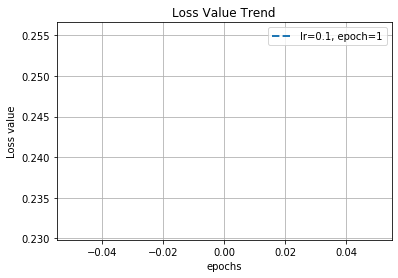

In [8]:
obj1.display_lossval_trend(loss_val_list, lr, epoch)

In [9]:
try:
    test_input_data = test_data[:, 0:-1]
    test_target_data = test_data[:, [-1]]

    accuracy_ret = obj1.accuracy(test_input_data, test_target_data)
    
    print('Accuracy => ', accuracy_ret)
    
except Exception as err:
    print(str(err))

name 'test_data' is not defined
